<a href="https://colab.research.google.com/github/IamShubhamGupto/WSSL-Weighted-Self-Supervised-Learning-for-Image-Inpainting/blob/main/notebooks/P2R4/Rotation_Sharpness_Pretext_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! git clone https://github.com/seshuad/IMagenet
! ls 'IMagenet/tiny-imagenet-200/'

Cloning into 'IMagenet'...
remote: Enumerating objects: 120594, done.
remote: Total 120594 (delta 0), reused 0 (delta 0), pack-reused 120594
Receiving objects: 100% (120594/120594), 212.68 MiB | 15.68 MiB/s, done.
Resolving deltas: 100% (1115/1115), done.
Checking out files: 100% (120206/120206), done.
test  train  val  wnids.txt  words.txt


In [ ]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 12.9 MB/s 


In [ ]:
import time
import scipy.ndimage as nd
import scipy.misc
import cv2
import numpy as np
import os
import glob
import gc
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import to_categorical
from PIL import Image, ImageEnhance
from random import randint
import pandas as pd
import tensorflow_addons as tfa
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, concatenate
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from google.colab.patches import cv2_imshow
import plotly.graph_objects as go
%matplotlib inline

In [ ]:
import random as rn
np.random.seed(4321)
rn.seed(4321)
tf.random.set_seed(4321)

Extract test and training data from Tiny ImageNet DataSet

In [ ]:

# path = '/content/drive/MyDrive/saved_images'

path = 'IMagenet/tiny-imagenet-200/'

def get_id_dictionary():
    id_dict = {}
    for i, line in enumerate(open( path + 'wnids.txt', 'r')):
        id_dict[line.replace('\n', '')] = i
    return id_dict
  
def get_class_to_id_dict():
    id_dict = get_id_dictionary()
    all_classes = {}
    result = {}
    for i, line in enumerate(open( path + 'words.txt', 'r')):
        n_id, word = line.split('\t')[:2]
        all_classes[n_id] = word
    for key, value in id_dict.items():
        result[value] = (key, all_classes[key])      
    return result

def get_data(id_dict):
    print('starting loading data')
    train_data, test_data = [], []
    train_labels, test_labels = [], []
    t = time.time()
    for key, value in id_dict.items():
        train_data += [cv2.imread( path + 'train/{}/images/{}_{}.JPEG'.format(key, key, str(i))) for i in range(500)]
        train_labels_ = np.array([[0]*200]*500)
        train_labels_[:, value] = 1
        train_labels += train_labels_.tolist()

    for line in open( path + 'val/val_annotations.txt'):
        img_name, class_id = line.split('\t')[:2]
        test_data.append(cv2.imread( path + 'val/images/{}'.format(img_name)))
        test_labels_ = np.array([[0]*200])
        test_labels_[0, id_dict[class_id]] = 1
        test_labels += test_labels_.tolist()

    print('finished loading data, in {} seconds'.format(time.time() - t))
    return np.array(train_data), np.array(train_labels), np.array(test_data), np.array(test_labels)
  
# train_data, train_labels, test_data, test_labels = get_data(get_id_dictionary())

# print( "train data shape: ",  train_data.shape )
# print( "train label shape: ", train_labels.shape )
# print( "test data shape: ",   test_data.shape )
# print( "test_labels.shape: ", test_labels.shape )

# del train_labels
# del test_labels
# gc.collect()

In [ ]:
train_data, train_labels, test_data, test_labels = get_data(get_id_dictionary())
print( "train data shape: ",  train_data.shape )
print( "train label shape: ", train_labels.shape )
print( "test data shape: ",   test_data.shape )
print( "test_labels.shape: ", test_labels.shape )

starting loading data
finished loading data, in 18.617671489715576 seconds
train data shape:  (100000, 64, 64, 3)
train label shape:  (100000, 200)
test data shape:  (10000, 64, 64, 3)
test_labels.shape:  (10000, 200)


In [ ]:
def rotate_image():
  return randint(0,3)

def sharpen_image():
  return randint(0,3)

In [ ]:
IM_WIDTH = IM_HEIGHT = 64
TRAIN_TEST_SPLIT = 0.8
dataset_dict = {
    'rotation_id': {
        0: '0', 
        1: '90', 
        2: '180', 
        3: '270', 
    },
    'sharpness_id': {
        0: '0.0',
        1: '0.25',
        2: '0.75',
        3: '1.0'
    }
}
dataset_dict['rotation_alias'] = dict((r, i) for i, r in dataset_dict['rotation_id'].items())
dataset_dict['sharpness_alias'] = dict((s, i) for i, s in dataset_dict['sharpness_id'].items())

In [ ]:
def prepare_dataset(dataset, ext='JPEG'):
    def generate_rotate_sharp():
      res_rot = rotate_image()
      res_sharp = sharpen_image()
      return [res_rot, res_sharp]
      # return dataset_dict['rotation_id'][res_rot], dataset_dict['sharpness_id'][res_sharp]
    id_dict = get_id_dictionary()
    files = []
    for key in id_dict.keys():
      files += [dataset + 'train/{}/images/{}_{}.JPEG'.format(key, key, str(i)) for i in range(500)]
    records = []
    files += glob.glob(dataset + 'val/images/*')
    for _ in files:
        info = generate_rotate_sharp()
        records.append(info)
        
    df = pd.DataFrame(records)
    df['image'] = files
    df.columns = ['rotation_id', 'sharpness_id', 'image']
    df = df.dropna()
    
    return df
df = prepare_dataset(path)
df.head()

,rotation_id,sharpness_id,image
0,2,0,IMagenet/tiny-imagenet-200/train/n02124075/ima...
1,3,0,IMagenet/tiny-imagenet-200/train/n02124075/ima...
2,1,2,IMagenet/tiny-imagenet-200/train/n02124075/ima...
3,0,0,IMagenet/tiny-imagenet-200/train/n02124075/ima...
4,1,0,IMagenet/tiny-imagenet-200/train/n02124075/ima...


In [ ]:
def plot_distribution(pd_series, key):
    labels = pd_series.value_counts().index.tolist()
    counts = pd_series.value_counts().values.tolist()
    labels = list(map(lambda id: dataset_dict[key][id], labels))
    # self.df['rotation_id'] = self.df['rotation'].map(lambda rotation: dataset_dict['rotation_alias'][rotation])
    pie_plot = go.Pie(labels=labels, values=counts, hole=.3)
    fig = go.Figure(data=[pie_plot])
    fig.update_layout(title_text='Distribution for %s' % pd_series.name)
    
    fig.show()

In [ ]:
plot_distribution(df['rotation_id'], 'rotation_id')

In [ ]:
plot_distribution(df['sharpness_id'], 'sharpness_id')

In [ ]:

class ImgDataGenerator():
    """
    Data generator for the Tiny imagenet dataset. This class should be used when training our Keras multi-output model.
    """
    def __init__(self, df):
        self.df = df
        
    def generate_split_indexes(self):
        self.df = self.df.sample(frac=1).reset_index(drop=True)
        train_up_to = int(len(self.df) * TRAIN_TEST_SPLIT)
        train_val_idx = self.df.tail(train_up_to)
        test_idx = self.df.head(len(self.df) - train_up_to)
        train_up_to = int(train_up_to * TRAIN_TEST_SPLIT)
        train_val_idx = train_val_idx.sample(frac=1).reset_index(drop=True)
        train_idx, valid_idx = train_val_idx.tail(train_up_to), train_val_idx.head(len(train_val_idx) - train_up_to)
        
        # # converts alias to id
        # self.df['rotation_id'] = self.df['rotation'].map(lambda rotation: dataset_dict['rotation_alias'][rotation])
        # self.df['sharpness_id'] = self.df['sharpness'].map(lambda sharpness: dataset_dict['sharpness_alias'][sharpness])
        
        return train_idx, valid_idx, test_idx
    
    
    def preprocess_image(self, rotate: int, sharpen: int, img_path):
        """
        Used to perform some minor preprocessing on the image before inputting into the network.
        """
        im_cv = cv2.imread(img_path)
        im = cv2.cvtColor(im_cv, cv2.COLOR_BGR2RGB)
        
        if rotate == 1:
          im = cv2.rotate(im, cv2.cv2.ROTATE_90_CLOCKWISE)
        elif rotate == 2:  
          im = cv2.rotate(im, cv2.ROTATE_180)
        elif rotate >= 3:
          im = cv2.rotate(im, cv2.ROTATE_90_COUNTERCLOCKWISE)

        enhancer = ImageEnhance.Sharpness(Image.fromarray(im))
        sharpness = 0.
        if sharpen == 1:
          sharpness = 0.25
          # out = unsharp_mask(im, amount=0.5)
        elif sharpen == 2:  
          sharpness = 0.75
          # out = unsharp_mask(im, amount = 1.5)
        elif sharpen >= 3:
          sharpness = 1.
          # out = unsharp_mask(im, amount = 2.5)
        
        out = np.array(enhancer.enhance(sharpness))
        # print(out.shape)
        out = out / 255.0
        
        return out
        
    def generate_images(self, image_idx, is_training, batch_size=16):
        """
        Used to generate a batch with images when training/testing/validating our Keras model.
        """
        
        # arrays to store our batched data
        images, rotations, sharps = [], [], []
        while True:
            for idx in range(len(image_idx)):
                row = image_idx.iloc[idx]
                
                rotation = row['rotation_id']
                sharpness = row['sharpness_id']
                
                im = self.preprocess_image(rotation, sharpness, row['image'])
                # print("rotation = ",rotation)
                # print("sharpness = ",sharpness)
                cat_rot = to_categorical(rotation, 4)
                cat_sharp = to_categorical(sharpness, 4)
                rotations.append(cat_rot)
                sharps.append(cat_sharp)
                # print("rotation = ",rotation,"cat_rot = ",cat_rot)
                # print("sharpness = ",sharpness,"cat_sharp = ",cat_sharp)
                images.append(im)
                
                # yielding condition
                if len(images) >= batch_size:
                    yield np.array(images), [np.array(rotations), np.array(sharps)]
                    images, rotations, sharps = [], [], []
                    
            if not is_training:
                break
                
data_generator = ImgDataGenerator(df)
train_idx, valid_idx, test_idx = data_generator.generate_split_indexes()

In [ ]:
print(train_idx.shape)
print(valid_idx.shape)
print(test_idx.shape)

(70400, 3)
(17600, 3)
(22000, 3)


In [ ]:
DEBUG = 0
if DEBUG:
  data_gen = data_generator.generate_images(test_idx, is_training=False, batch_size=8)
  # images = data_gen[0]
  for i,data in enumerate(data_gen):
    images, outputs = data
    print(len(images))
    for j, image in enumerate(images):
      image *= 255.0
      print("rotation ",outputs[0][j])
      print("sharpness ",outputs[1][j])
      cv2_imshow(image)
    break

In [ ]:
kernel = (3,3)
pool = (2,2)
upstride = (2,2)
activation = 'relu'
class inpaintingModel:
  def build_encoder(self, inputs):
    # inputs = keras.layers.Input(input_size)
    conv1, pool1 = self.__ConvBlock(64, kernel, pool, activation, 'same', inputs) 
    conv2, pool2 = self.__ConvBlock(128, kernel, pool, activation, 'same', pool1)
    conv3, pool3 = self.__ConvBlock(256, kernel, pool, activation, 'same', pool2) 
    conv4, pool4 = self.__ConvBlock(512, kernel, pool, activation, 'same', pool3) 
    conv5, pool5 = self.__ConvBlock(1024, kernel, pool, activation, 'same', pool4)

    return conv1, conv2, conv3, conv4, conv5, pool5

  def build_decoder(self, conv1, conv2, conv3, conv4, conv5, pool_layer):
    conv6, up7 = self.__UpConvBlock(2048, 1024, kernel, pool, upstride, activation, 'same', pool_layer, conv5)
    conv7, up8 = self.__UpConvBlock(1024, 512, kernel, pool, upstride, activation, 'same', up7, conv4)
    conv8, up9 = self.__UpConvBlock(512, 256, kernel, pool, upstride, activation, 'same', up8, conv3)
    conv9, up10 = self.__UpConvBlock(256, 128, kernel, pool, upstride, activation, 'same', up9, conv2)
    conv10, up11 = self.__UpConvBlock(128, 64, kernel, pool, upstride, activation, 'same', up10, conv1)

    conv11 = self.__ConvBlock(32, kernel, pool, activation, 'same', up11, False)
    
    outputs = keras.layers.Conv2D(3, kernel, activation='sigmoid', padding='same')(conv11)

    return outputs
  '''
  Build UNET like model for image inpaining task.
  '''
  def prepare_model(self, input_size=(64,64,3)):
    inputs = keras.layers.Input(input_size)
    conv1, conv2, conv3, conv4, conv5, pool_layer = self.build_encoder(inputs)
    outputs = self.build_decoder(conv1, conv2, conv3, conv4, conv5, pool_layer)
    # conv1, pool1 = self.__ConvBlock(64, kernel, pool, activation, 'same', inputs) 
    # conv2, pool2 = self.__ConvBlock(128, kernel, pool, activation, 'same', pool1)
    # conv3, pool3 = self.__ConvBlock(256, kernel, pool, activation, 'same', pool2) 
    # conv4, pool4 = self.__ConvBlock(512, kernel, pool, activation, 'same', pool3) 
    # conv5, pool5 = self.__ConvBlock(1024, kernel, pool, activation, 'same', pool4)
     

    # conv6, up7 = self.__UpConvBlock(2048, 1024, kernel, pool, upstride, activation, 'same', pool5, conv5)
    # conv7, up8 = self.__UpConvBlock(1024, 512, kernel, pool, upstride, activation, 'same', up7, conv4)
    # conv8, up9 = self.__UpConvBlock(512, 256, kernel, pool, upstride, activation, 'same', up8, conv3)
    # conv9, up10 = self.__UpConvBlock(256, 128, kernel, pool, upstride, activation, 'same', up9, conv2)
    # conv10, up11 = self.__UpConvBlock(128, 64, kernel, pool, upstride, activation, 'same', up10, conv1)

    # conv11 = self.__ConvBlock(64, kernel, pool, activation, 'same', up11, False)
    
    # outputs = keras.layers.Conv2D(3, kernel, activation='sigmoid', padding='same')(conv11)
    # inpur
    return keras.models.Model(inputs=[inputs], outputs=[outputs])  

  def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    if pool_layer:
      pool = keras.layers.MaxPooling2D(pool_size)(conv)
      return conv, pool
    else:
      return conv

  def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    up = keras.layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
    up = keras.layers.concatenate([up, shared_layer], axis=3)

    return conv, up

In [ ]:
class pretextModel:
  def assemble_head_branch(self,  pool_layer, name):
    x = Flatten()(pool_layer)
    x = Dense(512)(x)
    # x = BatchNormalization()(x)
    x = Activation("relu")(x)
        
    # x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    # x = Dense(2048, 
    #           kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
    #           bias_regularizer=tf.keras.regularizers.l2(1e-4),
    #           activity_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = Dense(512)(x)
    # x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(4)(x)
    x = Activation("softmax", name=name)(x)
    return x

  def assemble_pretext_model(self):
    inputs = keras.layers.Input((64,64,3))
    conv1, conv2, conv3, conv4, conv5, pool_layer = inpaintingModel().build_encoder(inputs) 
    rotation_branch = self.assemble_head_branch(pool_layer, "rotation_output")
    sharpness_branch = self.assemble_head_branch(pool_layer, "sharpness_output")
    model = Model(inputs=inputs,
                  outputs = [rotation_branch, sharpness_branch],
                  name="pretext_net")
    return model

In [ ]:
from tensorflow import keras

In [ ]:
keras.backend.clear_session()
p_model = pretextModel().assemble_pretext_model()

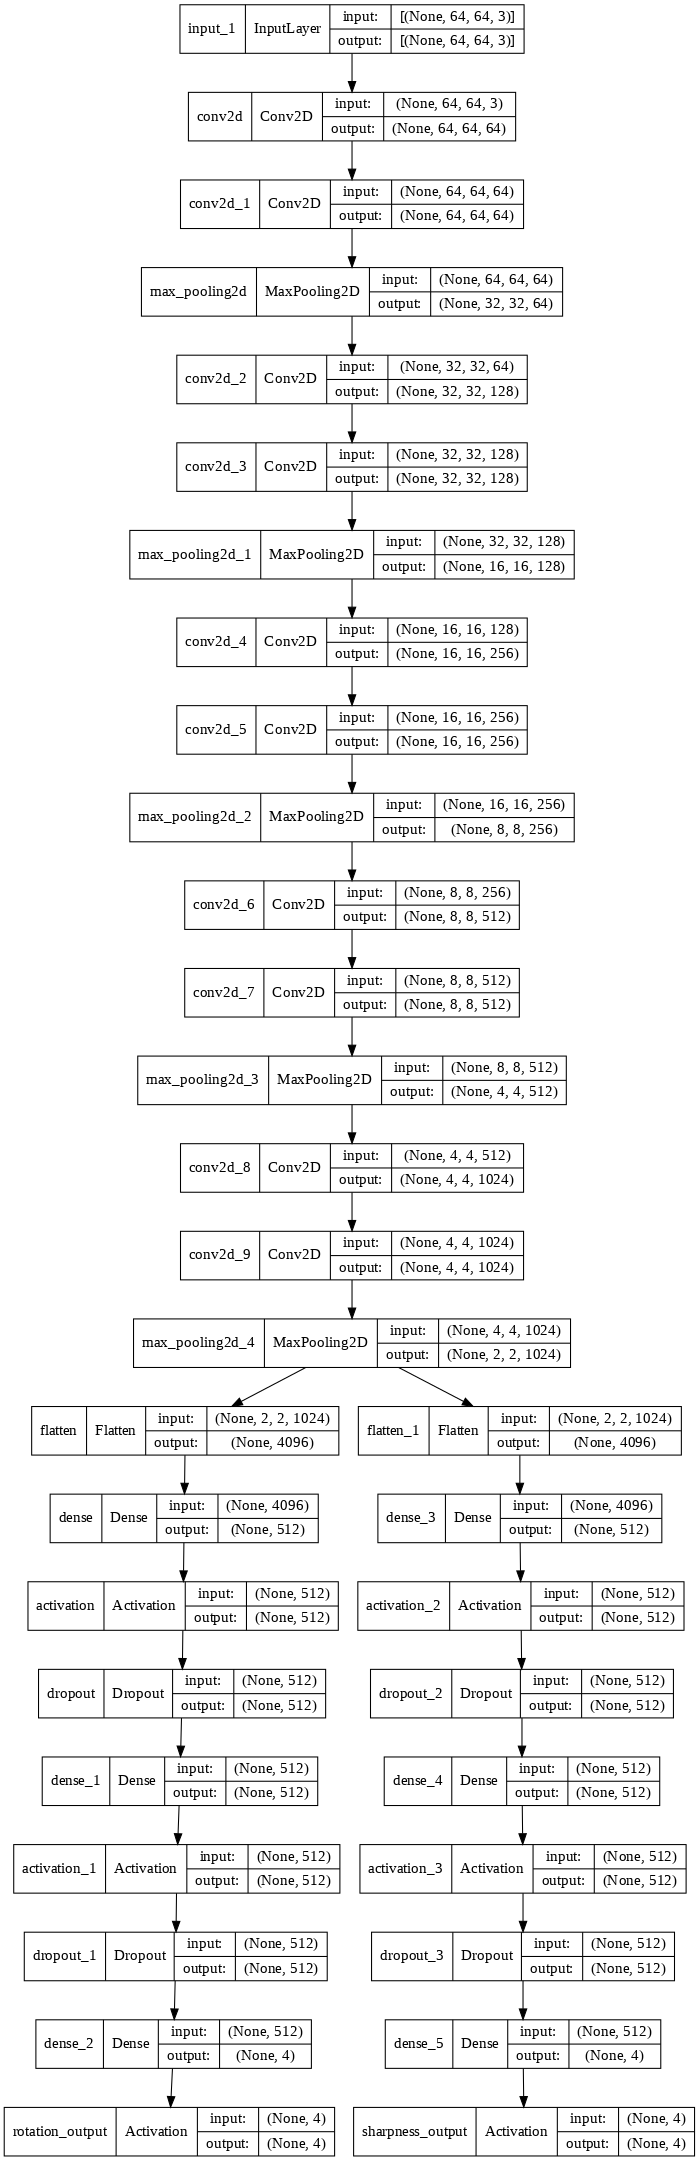

In [ ]:
tf.keras.utils.plot_model(p_model, show_shapes=True, dpi=76, to_file='p_model_v1.png')

In [ ]:
p_model.summary()

Model: "pretext_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 64)   36928       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 64)   0           ['conv2d_1[0][0]']               
                                                                                        

In [ ]:
init_lr = 1e-4
epochs = 50
opt = Adam(learning_rate=init_lr, amsgrad=False)
p_model.compile(optimizer=opt, 
              loss={
                  'rotation_output': 'categorical_crossentropy', 
                  'sharpness_output': 'categorical_crossentropy'},
              
              loss_weights={
                  'rotation_output': 0.7, 
                  'sharpness_output': 0.3},
              metrics={
                  'rotation_output': 'accuracy',
                  'sharpness_output': 'accuracy'})

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("./p_model_checkpoint", monitor='val_loss')
batch_size = 256
valid_batch_size = 256
train_gen = data_generator.generate_images(train_idx, is_training=True, batch_size=batch_size)
valid_gen = data_generator.generate_images(valid_idx, is_training=True, batch_size=valid_batch_size)
callbacks = [early_stopping, checkpoint]
history = p_model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    # class_weight=dict(
                    #     rotation_output = rots_dict,
                    #     sharpness_output = sharps_dict
                    # ), 
                    # use_multiprocessing=True,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

Epoch 1/50
275/275 [==============================] - 202s 576ms/step - loss: 1.2465 - rotation_output_loss: 1.3831 - sharpness_output_loss: 0.9278 - rotation_output_accuracy: 0.2653 - sharpness_output_accuracy: 0.5414 - val_loss: 1.1249 - val_rotation_output_loss: 1.3640 - val_sharpness_output_loss: 0.5670 - val_rotation_output_accuracy: 0.2996 - val_sharpness_output_accuracy: 0.7371
Epoch 2/50
275/275 [==============================] - 158s 575ms/step - loss: 1.1107 - rotation_output_loss: 1.3434 - sharpness_output_loss: 0.5676 - rotation_output_accuracy: 0.3325 - sharpness_output_accuracy: 0.7396 - val_loss: 1.0672 - val_rotation_output_loss: 1.3056 - val_sharpness_output_loss: 0.5108 - val_rotation_output_accuracy: 0.3842 - val_sharpness_output_accuracy: 0.7568
Epoch 3/50
275/275 [==============================] - 160s 581ms/step - loss: 1.0230 - rotation_output_loss: 1.2593 - sharpness_output_loss: 0.4718 - rotation_output_accuracy: 0.4193 - sharpness_output_accuracy: 0.7863 - val

In [ ]:
def plot_metric(metric):
  plt.clf()
  fig = go.Figure(layout_yaxis_range=[0,2])
  fig.add_trace(go.Scatter(
                      y=history.history[metric],
                      name='Train'))
  fig.add_trace(go.Scatter(
                      y=history.history['val_'+metric],
                      name='Valid'))
  fig.update_layout(height=500, 
                    width=700,
                    title=metric,
                    xaxis_title='Epoch',
                    yaxis_title='Accuracy/Loss')
  fig.show()

metrics = ['rotation_output_accuracy', 'rotation_output_loss', 'sharpness_output_accuracy', 'sharpness_output_loss', 'loss']
for i in metrics:
  plot_metric(i)

<Figure size 432x288 with 0 Axes>

In [ ]:
test_batch_size = 256
test_generator = data_generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size)
rotation_pred, sharpness_pred= p_model.predict(test_generator, 
                                                           steps=len(test_idx)//test_batch_size)

In [ ]:
test_generator = data_generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size)
samples = 0
images, rotation_true, sharpness_true = [], [], []
for test_batch in test_generator:
    image = test_batch[0]
    labels = test_batch[1]
    
    images.extend(image)
    rotation_true.extend(labels[0])
    sharpness_true.extend(labels[1])
    
rotation_true = np.array(rotation_true)
sharpness_true = np.array(sharpness_true)
rotation_true, sharpness_true = rotation_true.argmax(axis=-1), sharpness_true.argmax(axis=-1)
rotation_pred, sharpness_pred = rotation_pred.argmax(axis=-1), sharpness_pred.argmax(axis=-1)


In [ ]:
cr_rotation = classification_report(rotation_true, rotation_pred, target_names=dataset_dict['rotation_alias'].keys())
print(cr_rotation)

              precision    recall  f1-score   support

           0       0.56      0.50      0.53      5453
          90       0.53      0.53      0.53      5419
         180       0.56      0.53      0.54      5565
         270       0.51      0.59      0.55      5323

    accuracy                           0.54     21760
   macro avg       0.54      0.54      0.54     21760
weighted avg       0.54      0.54      0.54     21760



In [ ]:
cr_sharpness = classification_report(sharpness_true, sharpness_pred, target_names=dataset_dict['sharpness_alias'].keys())
print(cr_sharpness)

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      5382
        0.25       0.97      0.96      0.97      5498
        0.75       0.80      0.87      0.83      5534
         1.0       0.86      0.79      0.82      5346

    accuracy                           0.90     21760
   macro avg       0.90      0.90      0.90     21760
weighted avg       0.90      0.90      0.90     21760



In [ ]:
## Ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.
class createAugment(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, X, y, batch_size=128, dim=(64, 64), n_channels=3, shuffle=True):
      'Initialization'
      self.batch_size = batch_size 
      self.X = X 
      self.y = y
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle
      
      self.on_epoch_end()

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      return self.__data_generation(indexes)

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.X))
      if self.shuffle:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
    # X_batch is a matrix of masked images used as input
    X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Masked image
    # y_batch is a matrix of original images used for computing error from reconstructed image
    y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Original image

    ## Iterate through random indexes
    for i, idx in enumerate(idxs):
      image_copy = self.X[idx].copy()
  
      ## Get mask associated to that image
      masked_image = self.__createMask(image_copy)
      
      X_batch[i,] = masked_image/255
      y_batch[i] = self.y[idx]/255
      
    return X_batch, y_batch

  def __createMask(self, img):
    ## Prepare masking matrix
    mask = np.full((64,64,3), 255, np.uint8)
    for _ in range(np.random.randint(1, 10)):
      # Get random x locations to start line
      x1, x2 = np.random.randint(1, 64), np.random.randint(1, 64)
      # Get random y locations to start line
      y1, y2 = np.random.randint(1, 64), np.random.randint(1, 64)
      # Get random thickness of the line drawn
      thickness = np.random.randint(1, 7)
      # Draw black line on the white mask
      cv2.line(mask,(x1,y1),(x2,y2),(1,1,1),thickness)

    # Perforn bitwise and operation to mak the image
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image

In [ ]:
x_train, y_train, x_test, y_test = get_data(get_id_dictionary())

starting loading data
finished loading data, in 17.780527353286743 seconds


In [ ]:
## Prepare training and testing mask-image pair generator
d_train_gen = createAugment(x_train, x_train, batch_size=256)
d_test_gen = createAugment(x_test, x_test, shuffle=False, batch_size=256)

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

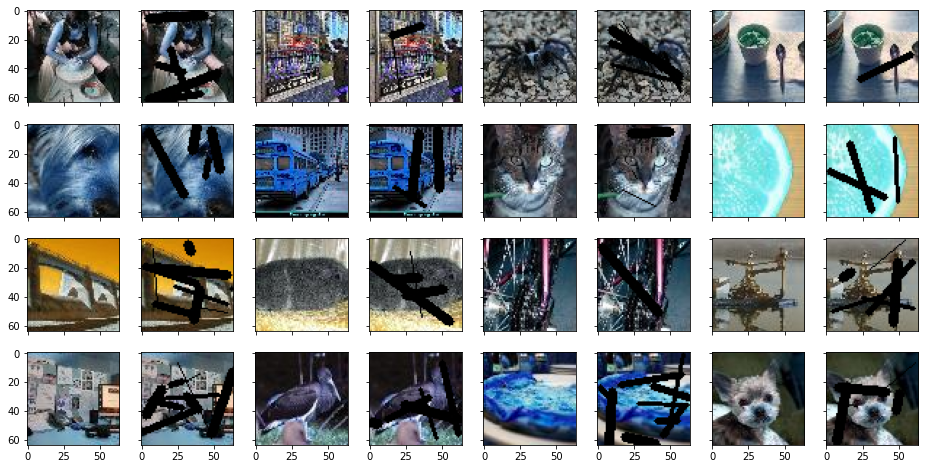

In [ ]:
## Examples
sample_idx = 90 ## Change this to see different batches

sample_masks, sample_labels = d_train_gen[sample_idx]
sample_images = [None]*(len(sample_masks)+len(sample_labels))
sample_images[::2] = sample_labels
sample_images[1::2] = sample_masks

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
  ax.imshow(image)

plt.show()

In [ ]:
## For more information into formulation: https://www.youtube.com/watch?v=AZr64OxshLo
## Metric
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

def dice_loss(y_true, y_pred):
  return 1 - dice_coef(y_true, y_pred)

def ssim_loss(y_true, y_pred):
  return 1 - SSIM(y_true, y_pred, multichannel=True)

def ssim_coef(y_true, y_pred):
  return 1 - SSIM(y_true, y_pred, multichannel=True)

def custom_loss(y_true, y_pred):
  alpha = 0.84
  loss_msssim = tf.image.ssim_multiscale(y_true, y_pred, 255)
  loss_mae = tf.keras.losses.mean_absolute_error(y_true, y_pred)
  return alpha*loss_msssim + (1-alpha)*loss_mae

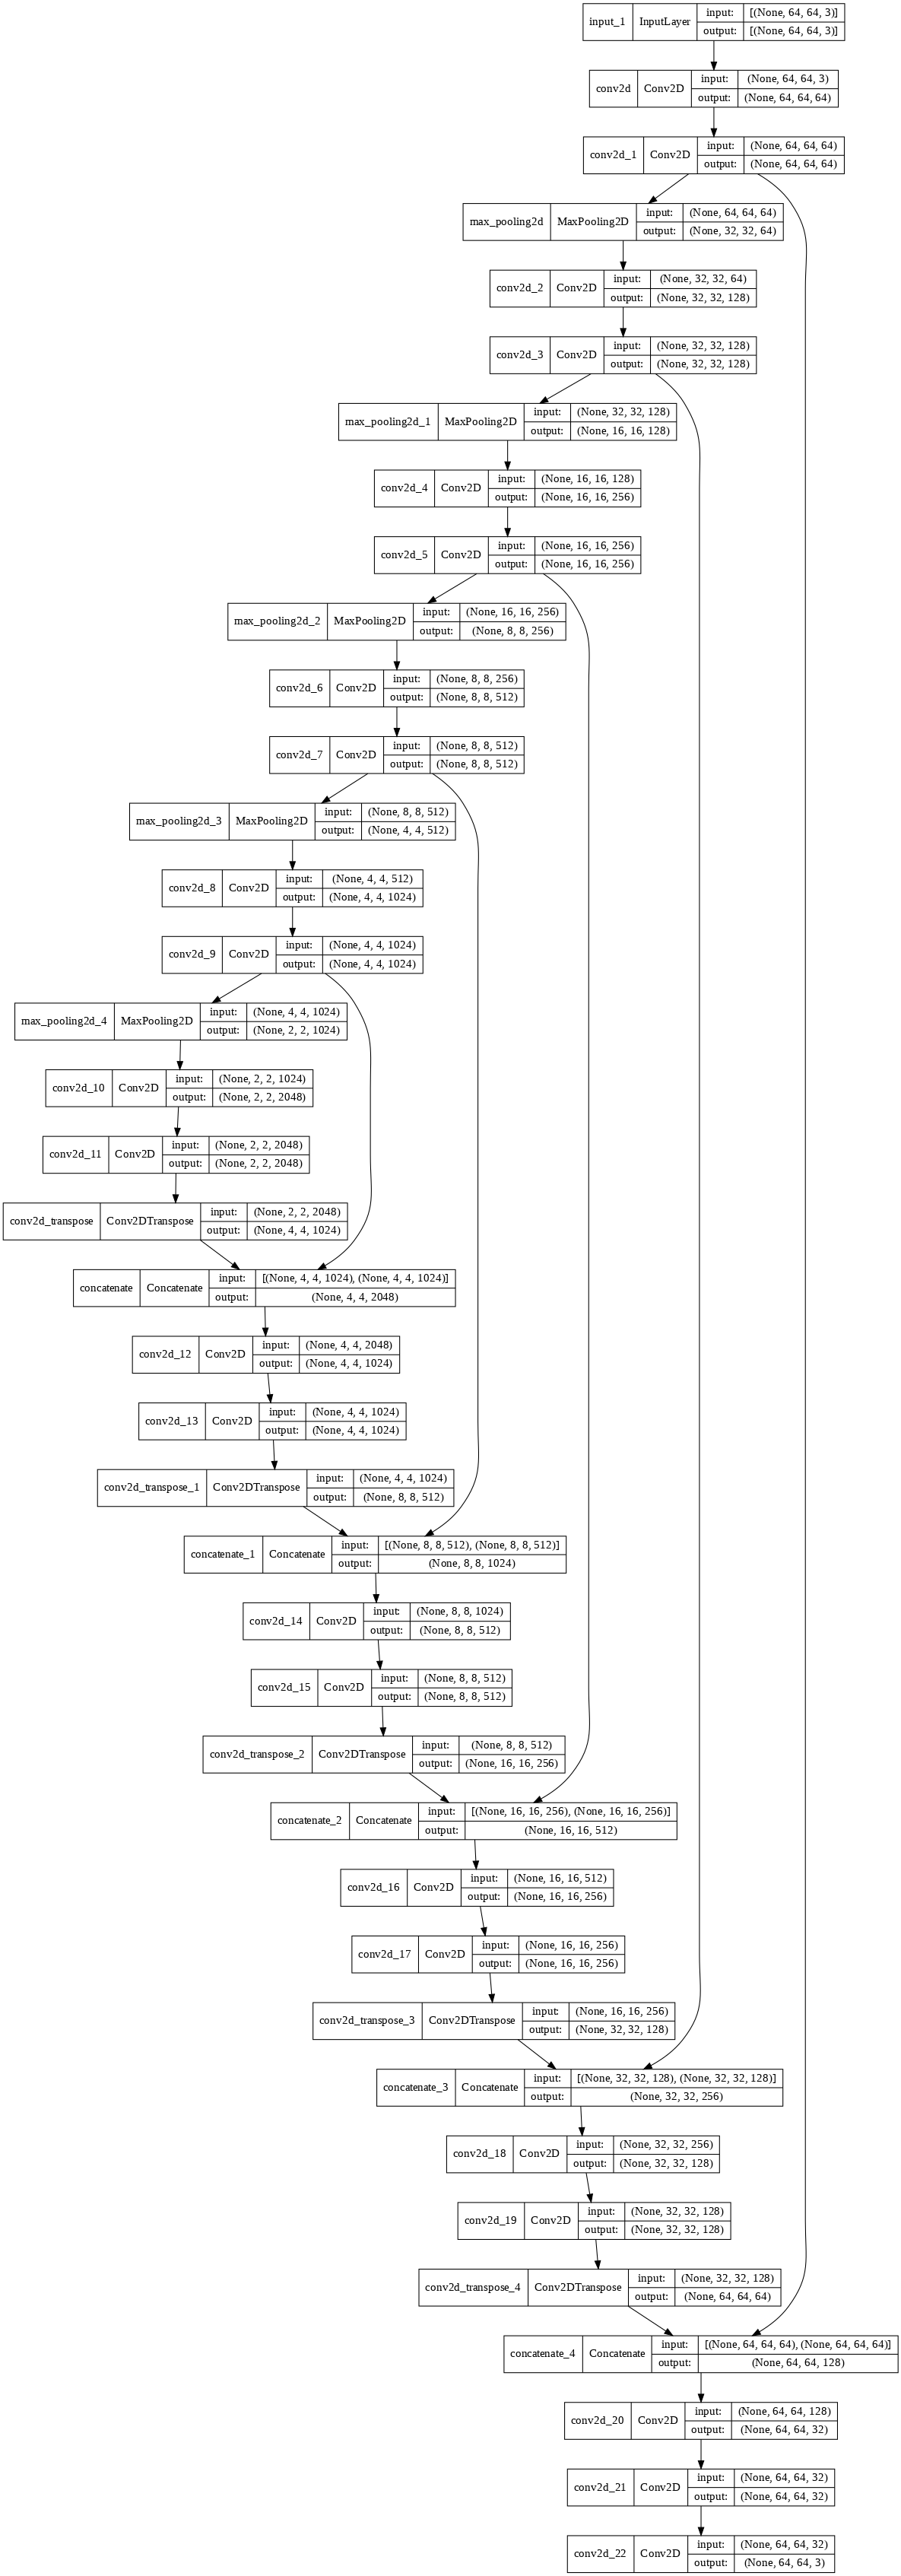

In [ ]:
keras.backend.clear_session()
d_model = inpaintingModel().prepare_model()
depth = 16
  # d_model.layers[:depth]:
  # print(i)
  # layer.set_weights(p_model.layers)
  # d_model.trainable_weights[i].assign(p_model.trainable_weights[i])
for i in range(depth):
  d_model.layers[i].set_weights(p_model.layers[i].get_weights())
  d_model.layers[i].trainable = False
d_model.compile(optimizer=opt, loss= 'mean_absolute_error', metrics=[dice_coef])

keras.utils.plot_model(d_model, show_shapes=True, dpi=76, to_file='d_model_v1.png')

In [ ]:
d_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 64)   36928       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 64)   0           ['conv2d_1[0][0]']               
                                                                                              

In [ ]:
# d_model.layers[5].get_weights()

# Trying again
## IT WORKS !!!

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)
checkpoint = ModelCheckpoint("./d_model_checkpoint", monitor='dice_coef')
batch_size = 256
valid_batch_size = 256
# train_gen = data_generator.generate_images(train_idx, is_training=True, batch_size=batch_size)
# valid_gen = data_generator.generate_images(valid_idx, is_training=True, batch_size=valid_batch_size)
callbacks = [early_stopping, checkpoint]
d_history = d_model.fit(d_train_gen,
                    # steps_per_epoch=len(d_train_gen)//batch_size,
                    epochs=4,
                    callbacks=callbacks,
                    # validation_split = 0.25
                    validation_data=d_test_gen,
                    # validation_steps = len(d_test_gen)//batch_size
                    )
                    # class_weight=dict(
                    #     rotation_output = rots_dict,
                    #     sharpness_output = sharps_dict
                    # ), 
                    # use_multiprocessing=True,
                    # validation_data=valid_gen,
                    # validation_steps=len(valid_idx)//valid_batch_size)

Epoch 1/4
390/390 [==============================] - 638s 2s/step - loss: 0.0977 - dice_coef: 0.5709 - val_loss: 0.0665 - val_dice_coef: 0.5953
Epoch 2/4
390/390 [==============================] - 614s 2s/step - loss: 0.0592 - dice_coef: 0.5947 - val_loss: 0.0538 - val_dice_coef: 0.5995
Epoch 3/4
390/390 [==============================] - 619s 2s/step - loss: 0.0509 - dice_coef: 0.5983 - val_loss: 0.0484 - val_dice_coef: 0.6013
Epoch 4/4
390/390 [==============================] - 617s 2s/step - loss: 0.0469 - dice_coef: 0.6001 - val_loss: 0.0452 - val_dice_coef: 0.6017


In [ ]:
from skimage.metrics import structural_similarity as SSIM
from skimage.metrics import peak_signal_noise_ratio as PSNR

In [ ]:
## Examples
rows = 64
sample_idx = 1
sample_images, sample_labels = d_test_gen[sample_idx]

fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(6, 2*rows))
mean_psnr = 0.0
mean_ssim = 0.0
for i in range(rows):
  impainted_image = d_model.predict(sample_images[i].reshape((1,)+sample_images[i].shape))
  axs[i][0].imshow(sample_labels[i])
  axs[i][1].imshow(sample_images[i])
  axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))
  mean_psnr += PSNR(sample_labels[i],impainted_image.reshape(impainted_image.shape[1:]))
  mean_ssim += SSIM(sample_labels[i],impainted_image.reshape(impainted_image.shape[1:]), multichannel=True)


plt.show()
print(f"Mean PSNR value = {mean_psnr/rows}")
print(f"Mean SSIM value = {mean_ssim/rows}")

In [ ]:
def find(model, rows, sample_images, sample_labels):
  mean_psnr = 0.0
  mean_ssim = 0.0
  for i in range(rows):
    impainted_image = d_model.predict(sample_images[i].reshape((1,)+sample_images[i].shape))
    mean_psnr += PSNR(sample_labels[i],impainted_image.reshape(impainted_image.shape[1:]))
    mean_ssim += SSIM(sample_labels[i],impainted_image.reshape(impainted_image.shape[1:]), multichannel=True)
  
  print("PSNR: ", mean_psnr/rows, "\nSSIM: ", mean_ssim/rows)
  return (mean_psnr/rows, mean_ssim/rows)

n_iterations = 5
total_psnr = 0.0
total_ssim = 0.0;
for i in range(n_iterations):
  psnr, ssim = find(d_model, rows, sample_images, sample_labels)
  total_psnr += psnr
  total_ssim += ssim

print(f"Mean of Mean PSNR value = {total_psnr/n_iterations}")
print(f"Mean of Mean SSIM value = {total_ssim/n_iterations}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning:

Inputs have mismatched dtype.  Setting data_range based on im_true.

/usr/local/lib/python3.7/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning:

Inputs have mismatched dtype.  Setting data_range based on im1.dtype.



PSNR:  22.816676487376174 
SSIM:  0.8323877455862299
PSNR:  22.816676487376174 
SSIM:  0.8323877455862299
PSNR:  22.816676487376174 
SSIM:  0.8323877455862299
PSNR:  22.816676487376174 
SSIM:  0.8323877455862299
PSNR:  22.816676487376174 
SSIM:  0.8323877455862299
Mean of Mean PSNR value = 22.816676487376174
Mean of Mean SSIM value = 0.8323877455862299


Fully supervised is 0.96 on cifar-10 (30 epochs) but yayy 0.85+ in just 2 epochs !!

In [ ]:
print(d_history.history)

{'loss': [0.09765402227640152, 0.05922258272767067, 0.050943080335855484, 0.04685971513390541], 'dice_coef': [0.5709081888198853, 0.5946640372276306, 0.5982958078384399, 0.6001088619232178], 'val_loss': [0.06654974818229675, 0.05384450778365135, 0.04838163033127785, 0.04523942992091179], 'val_dice_coef': [0.595276415348053, 0.5994582772254944, 0.6012895107269287, 0.6017176508903503]}


In [ ]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=d_history.history['dice_coef'],
                    name='Train'))
fig.add_trace(go.Scatter(
                    y=d_history.history['val_dice_coef'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy for image inpainting',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

<Figure size 432x288 with 0 Axes>